# Compute ToE hist + RCP85 vs. histNat (or PiControl) in lat/depth domain for one model, save ToE in output files

In [28]:
import sys
sys.path.append("/home/ysilvy/Density_bining/")
sys.path.append("/home/ysilvy/Density_bining/Yona_analysis/programs/")
import numpy as np
from netCDF4 import Dataset as open_ncfile
from maps_matplot_lib import defVarmme
from libToE import findToE
import glob
from functions_z_analysis import maptogamma
from binDensity import rhonGrid

In [29]:
# ----- Workspace ------

indir_histrcp85 = '/data/ysilvy/CMIP5_annual/'
indir_histNat = '/data/ysilvy/CMIP5_annual/'

# ----- Work ------

model = {'name':'IPSL-CM5A-LR'  ,'props':[6,3,11,156], 'picontrol':[1000],'correctFile':[0,0,0],
          'file_end_hist':'v20111119', 'file_end_histNat':'v20120430',
          'hist-rcp85':['r2i1p1','r3i1p1','r4i1p1']}

varname = defVarmme('salinity'); v = 'S'
#varname = defVarmme('temperature'); v = 'T'

multStd = 2. # detect ToE at multStd std dev of histNat or PiControl

use_piC = False # Signal = (hist-histNat) + RCP8.5-average(histNat), noise = std(histNat)
# use_piC = True # Signal = hist + RCP8.5 - PiControl, noise = std(PiControl)

iniyear = 1860
finalyear = 2100
deltay = 10.

# Define variable properties
legVar = varname['legVar']
unit = varname['unit']

if v=='S':
    var = 'salinity'
elif v=='T':
    var = 'temperature'

#model = models[10] # IPSL-CM5A-LR

In [30]:
# ----- Compute zonal ToE ------

print('Computing ToE for ',model['name'])

# Index of common time interval
tstart = model['props'][2]
tend = model['props'][3]

# Read histNat
filehn='so_thetao_gamma_Oan_IPSL-CM5A-LR_historicalNat_r2i1p1_185001-201012.nc'
fhn = open_ncfile(indir_histNat+filehn,'r')

# Read historical + rcp8.5
filehrcp = 'so_thetao_gamma_Oan_IPSL-CM5A-LR_historical-rcp85_r2i1p1_185001-210012.nc'
fhrcp = open_ncfile(indir_histrcp85+filehrcp,'r')

lat = fhn.variables['latitude'][:]
depth = fhn.variables['lev'][:]
latN = len(lat)
depthN = len(depth)
basinN=4
timN = 240

('Computing ToE for ', 'IPSL-CM5A-LR')


In [31]:
# Read var histNat
varhn_a = fhn.variables[var][tstart:tend,1,:,:].squeeze()
varhn_p = fhn.variables[var][tstart:tend,2,:,:].squeeze()
varhn_i = fhn.variables[var][tstart:tend,3,:,:].squeeze()

# Compute std of histNat
stdvarhn_a = np.ma.std(varhn_a, axis=0)
stdvarhn_i = np.ma.std(varhn_p, axis=0)
stdvarhn_p = np.ma.std(varhn_i, axis=0)

# Compute time average of the whole histNat series (signal over projection = RCP - mean(histNat))
meanvarhn_a = np.ma.mean(varhn_a, axis=0)
meanvarhn_p = np.ma.mean(varhn_p, axis=0)
meanvarhn_i = np.ma.mean(varhn_i, axis=0)

# Reorganise i,j dims in single dimension data (speeds up loops)
varnoise_a = np.reshape(stdvarhn_a, (depthN*latN))
varnoise_p = np.reshape(stdvarhn_p, (depthN*latN))
varnoise_i = np.reshape(stdvarhn_i, (depthN*latN))

In [32]:
varhn_a.shape
#varnoise_a.shape

(145, 31, 180)

In [33]:
# Read var hist + RCP8.5
varhrcp_a = fhrcp.variables[var][tstart-1:tend+95,1,:,:].squeeze()
varhrcp_p = fhrcp.variables[var][tstart-1:tend+95,2,:,:].squeeze()
varhrcp_i = fhrcp.variables[var][tstart-1:tend+95,3,:,:].squeeze()

In [34]:
varhrcp_a.shape

(240, 31, 180)

In [35]:
# Initialize and fill var_signal for each basin (timN, depth, latitude)
varsignal_a = np.ma.masked_all((timN,depthN,latN))
varsignal_p = np.ma.masked_all((timN,depthN,latN))
varsignal_i = np.ma.masked_all((timN,depthN,latN))

varsignal_a[0:145,:,:] = varhrcp_a[0:145,:,:]-varhn_a
varsignal_p[0:145,:,:] = varhrcp_p[0:145,:,:]-varhn_p
varsignal_i[0:145,:,:] = varhrcp_i[0:145,:,:]-varhn_i
varsignal_a[145:,:,:] = varhrcp_a[145:,:,:]-meanvarhn_a
varsignal_p[145:,:,:] = varhrcp_p[145:,:,:]-meanvarhn_p
varsignal_i[145:,:,:] = varhrcp_i[145:,:,:]-meanvarhn_i

In [36]:
varsignal_a.shape

(240, 31, 180)

In [37]:
# Initialize variable to save signal
varsignal_end = np.ma.masked_all((basinN,depthN,latN))
# Save signal
varsignal_end[1,:,:] = np.ma.average(varsignal_a[-5:,:,:],axis=0)
varsignal_end[2,:,:] = np.ma.average(varsignal_p[-5:,:,:],axis=0)
varsignal_end[3,:,:] = np.ma.average(varsignal_i[-5:,:,:],axis=0)

# Reorganise i,j dims in single dimension data (speeds up loops)
varsignal_a = np.reshape(varsignal_a, (timN, depthN*latN))
varsignal_p = np.reshape(varsignal_p, (timN, depthN*latN))
varsignal_i = np.reshape(varsignal_i, (timN, depthN*latN))
    
# Initialize ToE for each basin (depth, lat)
toe1_a = np.ma.masked_all((depthN,latN))
toe1_p = np.ma.masked_all((depthN,latN))
toe1_i = np.ma.masked_all((depthN,latN))
toe2_a = np.ma.masked_all((depthN,latN))
toe2_p = np.ma.masked_all((depthN,latN))
toe2_i = np.ma.masked_all((depthN,latN))

# Initialize output variable
varToE1 = np.ma.masked_all((basinN,depthN,latN)) # (>1std) (basin,depth,latitude)
varToE2 = np.ma.masked_all((basinN,depthN,latN)) # (>2std)

# Compute ToE as last date when diff hist+RCP - histNat is larger than mult * stddev
toe2_a = np.ma.reshape(findToE(varsignal_a, varnoise_a, multStd),(depthN,latN))
toe2_p = np.ma.reshape(findToE(varsignal_p, varnoise_p, multStd),(depthN,latN))
toe2_i = np.ma.reshape(findToE(varsignal_i, varnoise_i, multStd),(depthN,latN))
toe1_a = np.ma.reshape(findToE(varsignal_a, varnoise_a, 1),(depthN,latN))
toe1_p = np.ma.reshape(findToE(varsignal_p, varnoise_p, 1),(depthN,latN))
toe1_i = np.ma.reshape(findToE(varsignal_i, varnoise_i, 1),(depthN,latN))

# Save in output variable
varToE1[1,:,:] = toe1_a
varToE1[2,:,:] = toe1_p
varToE1[3,:,:] = toe1_i
varToE2[1,:,:] = toe2_a
varToE2[2,:,:] = toe2_p
varToE2[3,:,:] = toe2_i

# varToE1.fill_value = valmask
# varToE2.fill_value = valmask 

In [38]:
np.ma.masked_where(varsignal_end.mask==True,varToE2)

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., 149.0, 149.0, 149.0],
         [--, --, --, ..., 145.0, 149.0, 149.0],
         [--, --, --, ..., 145.0, 149.0, 149.0],
         ...,
         [--, --, --, ..., 221.0, 218.0, 172.0],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
        

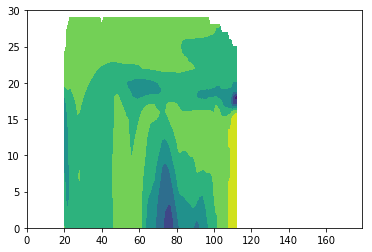

In [39]:
import matplotlib.pyplot as plt
#plt.contourf(varToE2[3,:,:])
plt.contourf(varsignal_end[3,:,:])

In [22]:
idx=np.argwhere(varsignal_end.mask==True)
varToE2[idx[:,0],idx[:,1],idx[:,2]]

masked_array(data=[--, --, --, ..., 240.0, 240.0, 240.0],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=1e+20)

In [23]:
varToE2[idx[:,0],idx[:,1],idx[:,2]] = np.ma.masked

In [24]:
varToE2[idx[:,0],idx[:,1],idx[:,2]]

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

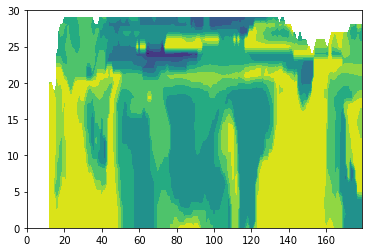

In [27]:
plt.contourf(varToE2[1,:,:])

In [71]:
# ---- Map ToE to gamma ----

# Density grid
targetrho, s_sax, del_s, N_s = rhonGrid(19, 26, 28.5, 0.2, 0.1)
levN = len(targetrho)

# Define Gamma/depth relationship for mapping
gammaz = np.ma.average(fhrcp.variables['density'][tstart:tend+95,:,:,:],axis=0)

# Map to gamma
varToE1_gamma = maptogamma(varToE1,gammaz,targetrho)
varToE2_gamma = maptogamma(varToE2,gammaz,targetrho)


In [44]:
targetrho, s_sax, del_s, N_s = rhonGrid(19, 26, 28.501, 0.2, 0.1)

In [45]:
targetrho

array([19.      , 19.2     , 19.400002, 19.600002, 19.800003, 20.000004,
       20.200005, 20.400005, 20.600006, 20.800007, 21.000008, 21.200008,
       21.40001 , 21.60001 , 21.80001 , 22.000011, 22.200012, 22.400013,
       22.600014, 22.800014, 23.000015, 23.200016, 23.400017, 23.600018,
       23.800018, 24.00002 , 24.20002 , 24.40002 , 24.600021, 24.800022,
       25.000023, 25.200024, 25.400024, 25.600025, 25.800026, 26.      ,
       26.1     , 26.2     , 26.300001, 26.400002, 26.500002, 26.600002,
       26.700003, 26.800003, 26.900003, 27.000004, 27.100004, 27.200005,
       27.300005, 27.400005, 27.500006, 27.600006, 27.700006, 27.800007,
       27.900007, 28.000008, 28.100008, 28.200008, 28.300009, 28.40001 ,
       28.50001 ], dtype=float32)

In [58]:
from scipy.interpolate import griddata
fieldz = varToE1

basinN = fieldz.shape[0]
depthN = fieldz.shape[1]
latN = fieldz.shape[2]

fieldgamma = np.ma.masked_all((basinN,len(targetrho),latN))

#for ibasin in range(basinN):
ibasin=1
#for ilat in range(latN):
ilat=65

gamz = gammaz[ibasin,:,ilat] # Read gamma (function of depth) of water column
print(gamz)
field_z = fieldz[ibasin,:,ilat] # Read field values of the water column
print(field_z)

field_sort = np.ma.compressed(field_z) # Remove masked values
print(field_sort)
gam_sort = gamz[np.where(field_z!=np.ma.masked)]
print(gam_sort)

if len(gam_sort) > 1:
    fieldgamma[ibasin,:,ilat] = griddata(gam_sort,field_sort,targetrho) # Grid field with target pressure grid
else :
    fieldgamma[ibasin,:,ilat] = np.ma.masked

fieldgamma[np.isnan(fieldgamma)] = np.ma.masked

# Mask out of bounds data
min = gamz[0]
idx = np.argmin(np.abs(targetrho-min))
fieldgamma[ibasin,0:idx-1,ilat] = np.ma.masked

print(fieldgamma[ibasin,:,ilat])
#return fieldgamma

[25.20127198287134 25.234900055570083 25.3108492416318 25.438188496992677
 25.553835561584727 25.652221168933053 25.732434133106693
 25.798017046940377 25.85255540664226 25.89964083747385 25.942858835643307
 25.985484358655857 26.030898600941423 26.083867922986403
 26.152484718226987 26.249358492416317 26.387137568645397
 26.515281773012553 26.73190090546548 27.143695655726987
 27.493288686584727 27.71705020920502 27.870188693122383
 27.970970760329497 28.00005107544456 28.01414381210774 28.026996436976987
 28.058258695083683 28.079391671025103 28.08087898797071 --]
[139.0 139.0 139.0 139.0 139.0 139.0 139.0 139.0 139.0 139.0 139.0 140.0
 140.0 140.0 140.0 141.0 144.0 182.0 191.0 188.0 189.0 136.0 96.0 96.0
 33.0 37.0 126.0 125.0 118.0 121.0 240.0]
[139. 139. 139. 139. 139. 139. 139. 139. 139. 139. 139. 140. 140. 140.
 140. 141. 144. 182. 191. 188. 189. 136.  96.  96.  33.  37. 126. 125.
 118. 121. 240.]
[25.20127198287134 25.234900055570083 25.3108492416318 25.438188496992677
 25.5538

In [59]:
lat[ilat]

-24.5

In [42]:
from scipy.interpolate import interp1d

basinN = fieldz.shape[0]
depthN = fieldz.shape[1]
latN = fieldz.shape[2]

fieldgamma2 = np.ma.masked_all((basinN,len(targetrho),latN))

#for ibasin in range(basinN):
ibasin=2
#for ilat in range(latN):
ilat=90

gamz = gammaz[ibasin,:,ilat] # Read gamma (function of depth) of water column
print(gamz)
field_z = fieldz[ibasin,:,ilat] # Read field values of the water column
print(field_z)

f = interp1d(gamz,field_z,bounds_error = False,kind='linear')

fieldgamma2[ibasin,:,ilat] = f(targetrho) # Interpolate field with target pressure grid

fieldgamma2[np.isnan(fieldgamma2)] = np.ma.masked

# Mask out of bounds data
min = gamz[0]
idx = np.argmin(np.abs(targetrho-min))
fieldgamma2[ibasin,0:idx-1,ilat] = np.ma.masked

print(fieldgamma2[ibasin,:,ilat])

[22.707828026935147 22.864110715219667 23.112727592180963
 23.404570639382847 23.50623937630753 23.605268534257323 23.70322510787134
 23.81336623953975 23.942190768828453 24.09986066618724 24.294999509675733
 24.53329710381799 24.813394841788703 25.127351513467573
 25.461260296809623 25.809523323091003 26.160969371077407
 26.501971512160043 26.79285025496862 27.065595171940377
 27.313842262683053 27.551990716527197 27.77916203582636
 27.937673656511507 27.976699382191423 27.988800176516737
 28.000192043671547 28.02245276542887 28.035689477641213 28.0497699561977
 --]
[235.0 240.0 240.0 240.0 240.0 240.0 240.0 240.0 240.0 234.0 234.0 229.0
 214.0 237.0 236.0 239.0 237.0 199.0 147.0 111.0 157.0 192.0 220.0 180.0
 145.0 145.0 145.0 145.0 240.0 186.0 240.0]
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 235.02373945537573
 237.94934998643717 240.0 240.0 240.0 240.0 240.0 237.79939079203115 234.0
 231.796429920589 225.4267334518599 214.71614554841358 227.67209380876926
 236.78235931

In [40]:
min = gamz[0]
idx = np.argmin(np.abs(targetrho-min))
fieldgamma2[ibasin,0:idx-1,ilat] = np.ma.masked

In [41]:
fieldgamma2[ibasin,:,ilat]

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, 235.02373945537573, 237.94934998643717,
                   240.0, 240.0, 240.0, 240.0, 240.0, 237.79939079203115,
                   234.0, 231.796429920589, 225.4267334518599,
                   214.71614554841358, 227.67209380876926,
                   236.78235931104265, 236.18339105109553,
                   237.19534549797612, 238.9181878428123,
                   237.91604029693704, 237.34696073526504,
                   232.6504880407823, 221.50682048554333,
                   210.36315293030432, 199.21948537506535,
                   181.47517045414662, 163.5982373162451,
                   146.05589190343153, 132.8566954788729,
                   119.65749905431423, 117.37596641994487,
                   135.90596221504413, 154.4359580101434,
                   169.66314216019552, 184.35991341755175,
                   197.91813632030505, 210.2436829156699,
           

In [39]:
targetrho

array([19.      , 19.2     , 19.400002, 19.600002, 19.800003, 20.000004,
       20.200005, 20.400005, 20.600006, 20.800007, 21.000008, 21.200008,
       21.40001 , 21.60001 , 21.80001 , 22.000011, 22.200012, 22.400013,
       22.600014, 22.800014, 23.000015, 23.200016, 23.400017, 23.600018,
       23.800018, 24.00002 , 24.20002 , 24.40002 , 24.600021, 24.800022,
       25.000023, 25.200024, 25.400024, 25.600025, 25.800026, 26.      ,
       26.1     , 26.2     , 26.300001, 26.400002, 26.500002, 26.600002,
       26.700003, 26.800003, 26.900003, 27.000004, 27.100004, 27.200005,
       27.300005, 27.400005, 27.500006, 27.600006, 27.700006, 27.800007,
       27.900007, 28.000008, 28.100008, 28.200008, 28.300009, 28.40001 ],
      dtype=float32)